# Exercises

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# default plot params
plt.rcParams.update({"figure.figsize": (10, 8), "font.size": 18})

## Exercise 1

What is the approximate depth of a decision tree trained (without restrictions) on a training set with one million instances?

---

No restrictions means that each leaf will have with 1 training instance. On average the tree will be balanced, so the number of children will double whenever we increase the depth. The question is how long can this continue until we run out of training instances. The answer is $log_2(m)$

In [2]:
print(np.log2(1e6))

19.931568569324174


So the depth will be 20 on average.

## Exercise 2

Is a node's Gini impurity generally lower or greater than its parent's? It is *generally* lower/greater, or *always* lower/greater?

---

The Gini impurity of a child is generally lower than its parent's because when splitting nodes we seek to minimise the weighted impurity of the children:

\begin{equation}
    \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}}.
\end{equation}

However, one child may have higher impurity if this is compensated for in the weighted sum by a lower impurity in the other child.

## Exercise 3

If a decision tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?

---

Yes. Decreasing `max_depth` simplifies the model and hence decreases the chance of overfitting.

## Exercise 4

If a decision tree is underfitting the training set, is it a good idea to try scaling the input features?

----

No. The decision tree training algorithm is scale invarient, so this won't make any difference.

## Exercise 5

If it takes one hour to train a decision tree on a training set contained 1 million instances, roughly how much time will it take to train another decision tree on a training set containing 10 million instances.

---

The computational complexity of training a decision tree is $O(m \log_2(m))$. So the increase in complexity will be:

In [3]:
cplx_old = 1e6 * np.log2(1e6)
cplx_new = 1e7 * np.log2(1e7)
cplx_new / cplx_old

11.666666666666666

So training the new tree will take approximately 11-12 hours.

## Exercise 6

If your training set contains 100,000 instances, will setting `presort=True` speed up training?

---

No. With a training set that size, presorting will probably take more time than it will actually save in traning.

## Exercise 7

Train and fine-tune a decision tree for the moons dataset by following these steps:

1. Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset.
2. Use `train_test_split()` to split the dataset into a training set and a test set.
3. Use grid search with cross-validation (with the help of the `GridSearchSV` class to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.
4. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

---

In [4]:
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree

from scipy import stats

RANDOM_STATE = 42

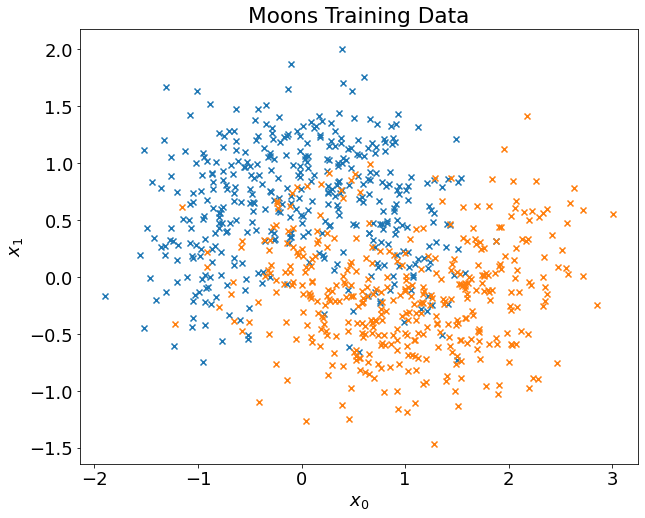

In [5]:
# generate data
X, y = make_moons(n_samples=1000, noise=0.4, random_state = RANDOM_STATE)

# separate test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# plot training data
def plot_dataset(X, y, ax=None, title=None):
    if not ax:
        fig, ax = plt.subplots()

    for k in np.unique(y):
        ax.scatter(X[y == k, 0], X[y == k, 1], marker="x")

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    if not title:
        title = "Moons Training Data"
        
    ax.set_title(title)


plot_dataset(X_train, y_train)

In [6]:
# decision tree hyperparameters
tree_clf = DecisionTreeClassifier()
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

**Relevant hyperparams**
- max_depth, max_leaf_nodes (both similar)
- min_samples_leaf, min_weight_fraction_leaf (equivalent), min_samples_split (similar)
- min_impurity_decrease
- criterion
- ccp_alpha (pruning - haven't really covered this)

**Irrelevant**
- max_features (how many features to check each split - not useful)
- splitter (this would just add more randomness - useful for forests but not for an individual tree)
- class_weight (classes are balanced)
- min_impurity_split (I think deprecated - not in the docs)

We have 800 training samples so an unconstrained tree will have depth ~10

In [7]:
# start with no regularisation for a baseline
cv_results = cross_validate(tree_clf, X_train, y_train, cv=5, scoring="accuracy", return_train_score=True)
print("Mean training accuracy: {:.2f}".format(cv_results["train_score"].mean()))
print("Mean test accuracy: {:.2f}".format(cv_results["test_score"].mean()))

Mean training accuracy: 1.00
Mean test accuracy: 0.78


As expected, this is overfitting. Let's try some regularisation.

In [8]:
def get_cv_summary(search):
    cv_results = search.cv_results_
    
    cv_summary = pd.DataFrame(cv_results["params"])
    cv_summary["mean_train_score"] = cv_results["mean_train_score"].round(3)
    cv_summary["mean_test_score"] = cv_results["mean_test_score"].round(3)
    cv_summary = cv_summary.sort_values(by="mean_test_score", ascending=False)
    
    return cv_summary

Begin with doing some coarse grid searches on the relevant parameters.

In [9]:
param_grid = [{
    "max_depth": range(1, 11)
}]

grid_search = GridSearchCV(
    tree_clf,
    param_grid,
    cv=5,
    scoring="accuracy",
    return_train_score=True,
    refit=False,
)

grid_search.fit(X_train, y_train)
cv_summary = get_cv_summary(grid_search)
cv_summary

,max_depth,mean_train_score,mean_test_score
1,2,0.872,0.849
2,3,0.872,0.849
3,4,0.877,0.846
4,5,0.891,0.832
5,6,0.909,0.830
6,7,0.925,0.828
7,8,0.937,0.814
8,9,0.952,0.804
9,10,0.963,0.798
0,1,0.785,0.765


Seems like low values of max_depth are more effective.

What if we vary max leaf nodes. This should vaguely give the same answer, but gives a bit more control. If we're thinking of the same range as max depth was best at, then that's between $2^2=4$ and 2^6 = 64.

In [10]:
param_grid = [{
    "max_leaf_nodes": range(2, 64, 2)
}]

grid_search = GridSearchCV(
    tree_clf,
    param_grid,
    cv=5,
    scoring="accuracy",
    return_train_score=True,
    refit=False,
)

grid_search.fit(X_train, y_train)
cv_summary = get_cv_summary(grid_search)
cv_summary.head(10)

,max_leaf_nodes,mean_train_score,mean_test_score
2,6,0.872,0.850
1,4,0.872,0.849
3,8,0.879,0.847
6,14,0.894,0.844
7,16,0.896,0.844
5,12,0.888,0.839
8,18,0.902,0.839
4,10,0.885,0.838
9,20,0.907,0.835
12,26,0.918,0.835


So not many nodes is best - similar to max_depth.

Let's try min_samples_leaf instead.

In [11]:
param_grid = [{
    "min_samples_leaf": range(2, 201, 5)
}]

grid_search = GridSearchCV(
    tree_clf,
    param_grid,
    cv=5,
    scoring="accuracy",
    return_train_score=True,
    refit=False,
)

grid_search.fit(X_train, y_train)
cv_summary = get_cv_summary(grid_search)
cv_summary.head(10)

,min_samples_leaf,mean_train_score,mean_test_score
5,27,0.871,0.851
4,22,0.878,0.850
6,32,0.869,0.849
2,12,0.886,0.846
3,17,0.883,0.846
7,37,0.867,0.842
8,42,0.861,0.836
9,47,0.853,0.835
1,7,0.898,0.835
10,52,0.844,0.822


I guess these are basically doing the same thing so no improvement.

Let's try impurity instead.

In [12]:
param_grid = [{
    "min_impurity_decrease": [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
}]

grid_search = GridSearchCV(
    tree_clf,
    param_grid,
    cv=5,
    scoring="accuracy",
    return_train_score=True,
    refit=False,
)

grid_search.fit(X_train, y_train)
cv_summary = get_cv_summary(grid_search)
cv_summary

,min_impurity_decrease,mean_train_score,mean_test_score
5,0.0100,0.872,0.850
6,0.0300,0.872,0.849
4,0.0030,0.894,0.844
3,0.0010,0.955,0.817
2,0.0003,0.993,0.795
0,0.0000,1.000,0.789
1,0.0001,0.999,0.785
7,0.1000,0.785,0.765
8,0.3000,0.500,0.500


I still can't get past 0.85 mean test score.

Finally lets try combining all of these (and criterion) with a randomised search. I'll use a log uniform distribution for min impurity to get different scales.

In [13]:
param_dist = {
    "max_leaf_nodes": stats.randint(low=6, high=16),
    "min_samples_leaf": stats.randint(low=10, high=30),
    "min_impurity_decrease": stats.loguniform(a=0.001, b=0.1),
    "criterion": ["gini", "entropy"],
}

rand_search = RandomizedSearchCV(
    tree_clf,
    param_dist,
    n_iter=2000,
    scoring="accuracy",
    refit=True,
    cv=5,
    return_train_score=True,
    random_state=RANDOM_STATE,
)

rand_search.fit(X_train, y_train)
tree_best = rand_search.best_estimator_

cv_summary = get_cv_summary(rand_search)
cv_summary

,criterion,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,mean_train_score,mean_test_score
1807,entropy,14,0.001787,23,0.878,0.859
1406,entropy,14,0.001794,23,0.878,0.859
605,entropy,15,0.001177,26,0.874,0.858
8,entropy,14,0.001239,28,0.873,0.856
1850,entropy,12,0.002952,23,0.877,0.855
...,...,...,...,...,...,...
47,gini,15,0.093605,13,0.785,0.765
1110,gini,13,0.080737,22,0.785,0.765
44,gini,6,0.098965,26,0.785,0.765
405,gini,6,0.080408,18,0.785,0.765


Entropy actually seems to give a big improvement.

Let's take a look at the best model.

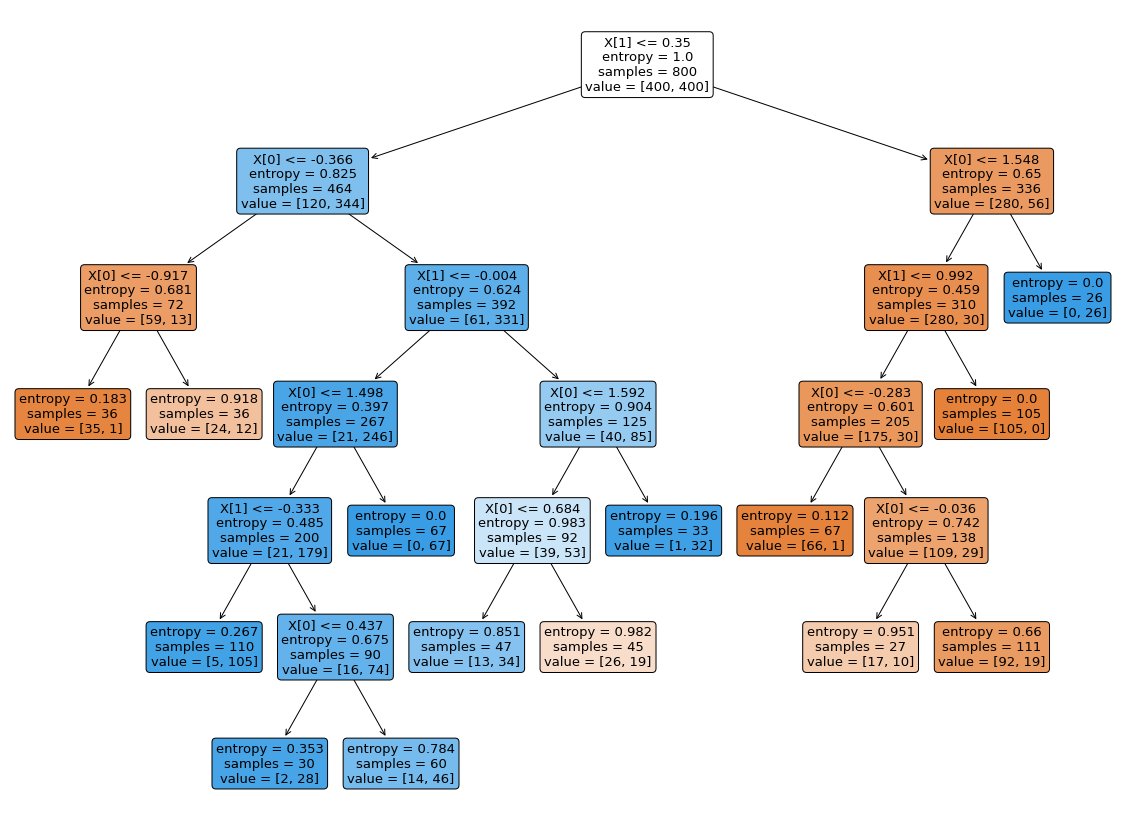

In [14]:
fig, ax = plt.subplots(figsize=(20, 15))

plot_tree(
    tree_best,
    rounded=True,
    filled=True,
);

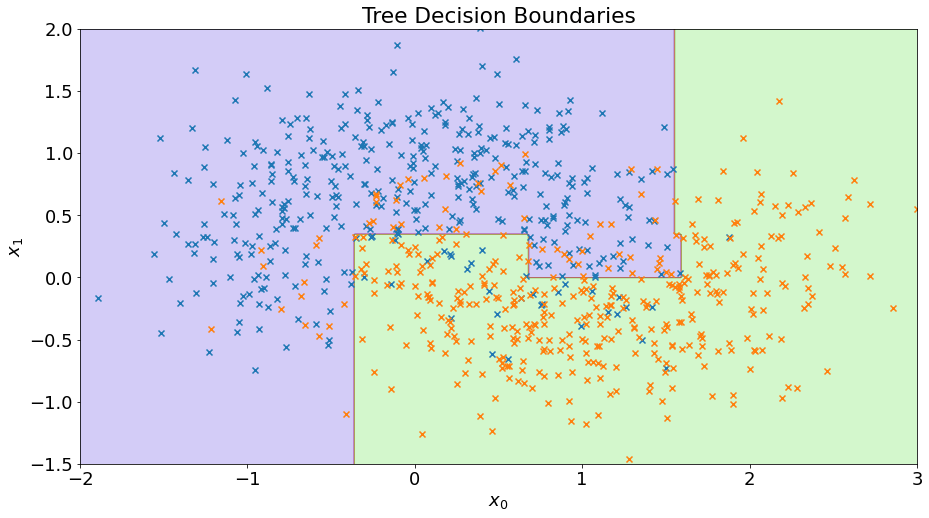

In [15]:
def plot_class_predictions(clf, xlim, ylim, ax):
    # generate values along each axis
    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)
    
    # all combinations of (x0, x1) for plot
    x0, x1 = np.meshgrid(x0s, x1s)

    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    
    ax.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_decision_boundaries(clf, ax=None, title=None):
    xlim = np.array([-2, 3])
    ylim = np.array([-1.5, 2])
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(15, 8))

    plot_class_predictions(clf, xlim, ylim, ax)
    plot_dataset(X_train, y_train, ax, title=title)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


plot_decision_boundaries(tree_best, title="Tree Decision Boundaries");

Looks pretty reasonable. Finally lets test the model.

In [16]:
y_train_pred = tree_best.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: {:.3f}".format(acc_train))

y_test_pred = tree_best.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: {:.3f}".format(acc_test))

Training Accuracy: 0.879
Test Accuracy: 0.840


Damn, that isn't great.

Testing the tree in the textbook exercises to make myself feel better.

In [17]:
tree_geron = DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)
tree_geron.fit(X_train, y_train)

y_train_pred = tree_geron.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: {:.3f}".format(acc_train))

y_test_pred = tree_geron.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: {:.3f}".format(acc_test))

Training Accuracy: 0.891
Test Accuracy: 0.830


This is actually worse than in the textbook solutions and worse than mine, so I guess I did fine.

## Exercise 8

Grow a forest by following these steps:

1. Continuing the previous exercise, generate 1,000 subsets of the training set, each cntaininng 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` class for this.
2. Train one decision tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 decision trees on the test set. Since they were trained on smaller sets, these decision trees will likely perform worse than the first decision tree, achieving only about 80% accuracy.
3. Now comes the magic. For each test set instance, generate the predictions of the 1,000 decision trees and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This approach gives you *majority-vote predictions* over the test set.
---

In [88]:
from sklearn.model_selection import ShuffleSplit

# split training set into 1000 subsets of size 100
n_trees = 1000
spl = ShuffleSplit(n_splits=n_trees, train_size=100, random_state=RANDOM_STATE)

In [98]:
# best decision tree from last exercise
# tree_clf = DecisionTreeClassifier()
# tree_clf.set_params(**rand_search.best_params_);

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=14,
                       min_impurity_decrease=0.0017942742623249049,
                       min_samples_leaf=23)

In [104]:
# lets remove some of the regularisation from my best tree
tree_clf = DecisionTreeClassifier(max_leaf_nodes=14)
tree_clf.fit(X_train, y_train)

y_train_pred = tree_clf.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: {:.3f}".format(acc_train))

y_test_pred = tree_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: {:.3f}".format(acc_test))

Training Accuracy: 0.889
Test Accuracy: 0.840


In [102]:
# training the decision tree on each subset
def accuracy(clf, X, y):
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)

    return acc


accs_train = np.array([])
accs_test = np.array([])

for train_ix, _ in spl.split(X_train, y_train):
    X_train_sub = X_train[train_ix, :]
    y_train_sub = y_train[train_ix]
    
    tree_clf.fit(X_train_sub, y_train_sub)
    
    accs_train = np.append(accs_train, accuracy(tree_clf, X_train_sub, y_train_sub))
    accs_test = np.append(accs_test, accuracy(tree_clf, X_test, y_test))


print("Training accuracy mean: {:.3f}".format(accs_train.mean()))
print("Training accuracy st dev: {:.3f}".format(accs_train.std()))
print("")
print("Test accuracy mean: {:.3f}".format(accs_test.mean()))
print("Test accuracy st dev: {:.3f}".format(accs_test.std()))

Training accuracy mean: 0.970
Training accuracy st dev: 0.020

Test accuracy mean: 0.795
Test accuracy st dev: 0.031


I'll find the most common prediction by taking the average. Since the problem is binary, the most common class is 1 if the avg is over 0.5 and 0 if it's less than 0.5.

In [103]:
# majority-vote predictions
n_train = len(y_train)
n_test = len(y_test)

y_train_pred = np.zeros(n_train)
y_test_pred = np.zeros(n_test)

counter = 0
for train_ix, _ in spl.split(X_train, y_train):
    X_train_sub = X_train[train_ix, :]
    y_train_sub = y_train[train_ix]
    
    tree_clf.fit(X_train_sub, y_train_sub)
    
    y_train_pred += tree_clf.predict(X_train)
    y_test_pred += tree_clf.predict(X_test)
    
    counter += 1

y_train_pred = (y_train_pred / n_trees).round(0)
y_test_pred = (y_test_pred / n_trees).round(0)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print("Training accuracy: {:.3f}".format(acc_train))
print("Test accuracy: {:.3f}".format(acc_test))

Training accuracy: 0.881
Test accuracy: 0.850


Interestingly, for my 'best' decision tree this gave a much worse score. I think that tree was underfitting on 100 training samples since it was optimised for 800 samples. Adding more trees wouldn't help since this generally increases bias but decreases variance.

However, with this simpler decision tree it improves test accuracy by 1%.